In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
sys.path.append('/home/njr61/rds/hpc-work/spurious-concepts/ConceptBottleneck')

In [4]:
import torch
from sklearn.metrics import roc_auc_score
from sklearn.neural_network import MLPClassifier
import torch.nn as nn
import torch.optim as optim
import pickle
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from captum.attr import visualization as viz
from matplotlib.colors import LinearSegmentedColormap
import cv2
from copy import copy 
import itertools
from matplotlib.patches import Circle
import json

In [5]:
from ConceptBottleneck.CUB.models import ModelXtoC, ModelOracleCtoY
from ConceptBottleneck.CUB.dataset import load_data

In [6]:
from src.images import *
from src.util import *
from src.models import *
from src.plot import *

## Set up dataset + model

In [7]:
dataset = 'CUB'
noisy=False
weight_decay = 0.0004
encoder_model='small3'
optimizer = 'sgd'

In [8]:
def get_log_folder(dataset,weight_decay,encoder_model,optimizer):
    if weight_decay == 0.0004 and encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint"
    elif weight_decay == 0.0004:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}"
    elif encoder_model == 'inceptionv3':
        log_folder = f"results/{dataset}/joint_wd_{weight_decay}"
    else:
        log_folder = f"results/{dataset}/joint_model_{encoder_model}_wd_{weight_decay}"
    if optimizer != 'sgd':
        log_folder += "_opt_{}".format(optimizer)
    
    log_folder += '/joint'
    
    return log_folder

In [9]:
dataset_name = "CUB"
data_dir = "../cem/cem/{}/preprocessed/".format(dataset_name)
data_dir

'../cem/cem/CUB/preprocessed/'

In [10]:
train_data_path = os.path.join(data_dir, 'train.pkl')
val_data_path = train_data_path.replace('train.pkl', 'val.pkl')

In [11]:
pretrained = True
freeze = False
use_aux = True
expand_dim = 0
three_class = False
use_attr = True
no_img = False
batch_size = 64
uncertain_labels = False
image_dir = 'images'
num_class_attr = 2
resampling = False

In [12]:
train_loader = load_data([train_data_path], use_attr, no_img, batch_size, uncertain_labels, image_dir=image_dir, 
                         n_class_attr=num_class_attr, resampling=resampling, path_transform=lambda path: "../cem/cem/"+path, is_training=False)
val_loader = load_data([val_data_path], use_attr, no_img=False, batch_size=64, image_dir=image_dir, n_class_attr=num_class_attr, path_transform=lambda path: "../cem/cem/"+path)

In [13]:
log_folder = get_log_folder(dataset_name,weight_decay,encoder_model,optimizer)
joint_location = "ConceptBottleneck/{}/best_model_42.pth".format(log_folder)
print(joint_location)
joint_model = torch.load(joint_location,map_location=torch.device('cpu'))
r = joint_model.eval()

ConceptBottleneck/results/CUB/joint_model_small3/joint/best_model_42.pth


## Plot the Dataset

In [14]:
train_pkl = pickle.load(open(train_data_path,"rb"))
val_pkl = pickle.load(open(val_data_path,"rb"))


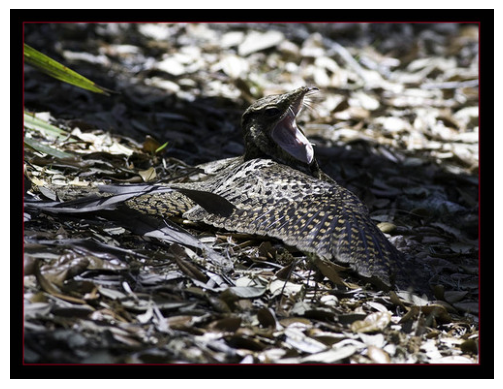

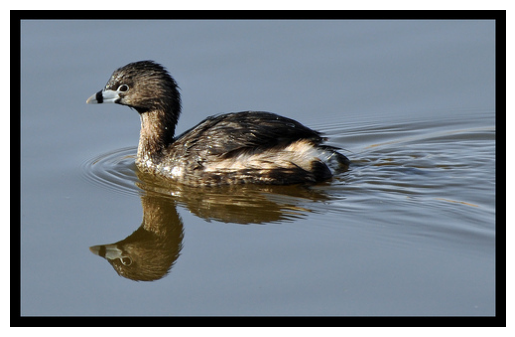

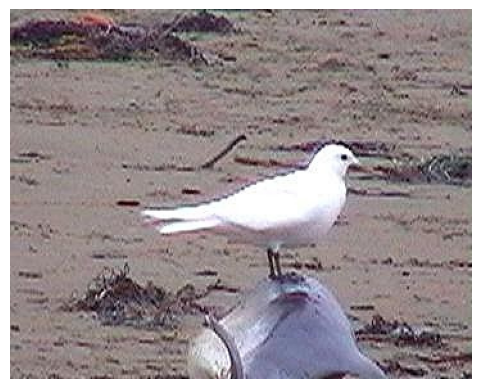

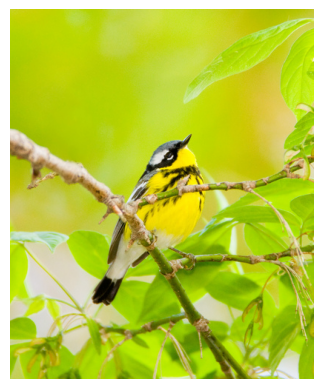

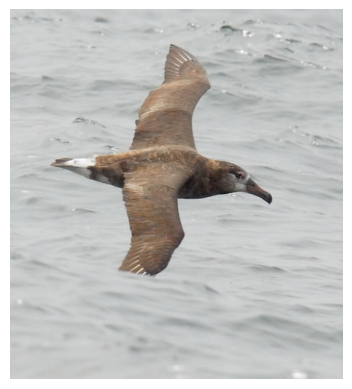

In [15]:
num_images_show = 5
for i in range(num_images_show):
    img_path = '../cem/cem/'+train_pkl[i]['img_path']
    image = Image.open(img_path)
    image_array = np.array(image)
    plt.figure()
    plt.imshow(image_array)
    plt.axis('off') 

In [16]:
val_images, val_y, val_c = unroll_data(val_loader)

In [ ]:
get_accuracy(joint_model,run_joint_model,train_loader), get_accuracy(joint_model,run_joint_model,val_loader)

(tensor(0.9352), tensor(0.9349))

In [18]:
get_concept_accuracy_by_concept(joint_model,run_joint_model,train_loader,sigmoid=True)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 0.9994, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000])

## Saliency Maps

In [17]:
val_pkl[1]['attribute_label']

[1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [19]:
attributes = open("../cem/cem/CUB/metadata/attributes.txt").read().split("\n")

In [20]:
attributes[0]

'2 has_bill_shape::dagger'

In [21]:
attribute_num = 0
dataset_num = 1

In [26]:
val_c[0][8]

tensor(1)

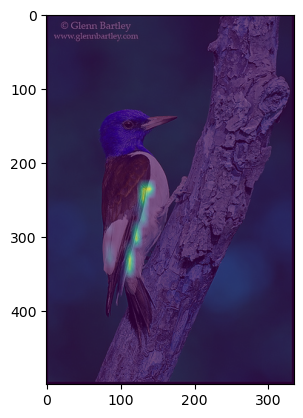

In [25]:
plot_gradcam(joint_model,run_joint_model,attribute_num,val_images,dataset_num,val_pkl)

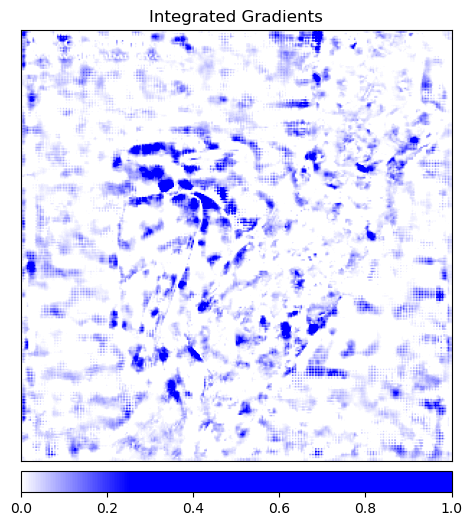

In [23]:
plot_integrated_gradients(joint_model,run_joint_model,attribute_num,val_images,dataset_num)

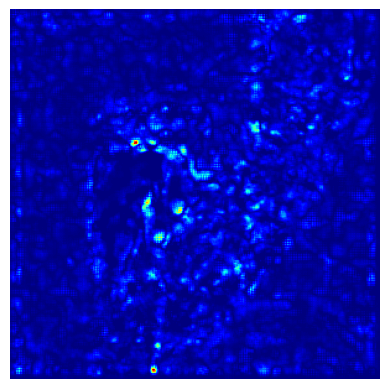

In [24]:
plot_saliency(joint_model,run_joint_model,attribute_num,val_images,dataset_num)

## Using Part Annotations

In [17]:
part_file = open("../cem/cem/CUB/metadata/parts/part_locs.txt").read().strip().split("\n")

In [18]:
part_list = open("../cem/cem/CUB/metadata/parts/parts.txt").read().strip().split("\n")
part_list = [' '.join(i.split(' ')[1:]) for i in part_list]

In [19]:
attribute_names = open("../cem/cem/CUB/metadata/attributes.txt").read().strip().split("\n")
attribute_names = [' '.join(i.split(' ')[1:]) for i in attribute_names]

In [20]:
parts_to_attribute = {}

for i in range(len(part_list)):
    if 'left' in part_list[i] or 'right' in part_list[i]:
        opposite = part_list[i].replace('left','RIGHT').replace('right','LEFT').lower()
        indices = sorted([i,part_list.index(opposite)])
        current_name = '^'.join([str(j) for j in indices])
    else:
        current_name = str(i)
    
    parts_to_attribute[current_name] = [] 
    parts_split = part_list[i].split(' ')

    for j in range(len(attribute_names)):
        main_part = set(attribute_names[j].split("::")[0].split("_"))

        if len(main_part.intersection(parts_split)) > 0:
            parts_to_attribute[current_name].append(j)

In [21]:
locations_by_image = {}
for i in part_file:
    split_vals = i.split(' ')

    if split_vals[-1] == '1':
        image_id = int(split_vals[0])
        part_id = int(split_vals[1])-1 # 0 index 
        x = float(split_vals[2])
        y = float(split_vals[3])

        if image_id not in locations_by_image:
            locations_by_image[image_id] = {}
        locations_by_image[image_id][part_id] = (x,y)

In [25]:
valid_parts = [int(i) for i in parts_to_attribute if '^' not in i and parts_to_attribute[i] != []]

#### Impact of Epsilon on Predictions

In [22]:
diff_results = {
    'mean': {},
    'std': {},
}

In [28]:
for part_num in valid_parts: 
    diff_results['mean'][part_list[part_num]] = {}
    diff_results['std'][part_list[part_num]] = {}
    for epsilon in [10,20,30,40,50]:
        # Get the corresponding data points
        corresponding_attributes = parts_to_attribute[str(part_num)]
        data_points = [i for i in range(100) if sum(val_c[i][corresponding_attributes])>0]
        data_points = [i for i in data_points if part_num in locations_by_image[val_pkl[i]['id']]]
        new_images = torch.stack([mask_part(i,part_num,locations_by_image,val_pkl,val_images,epsilon=epsilon) for i in data_points])

        _, initial_predictions = run_joint_model(joint_model,val_images[data_points])
        initial_predictions = torch.nn.Sigmoid()(initial_predictions.T)

        _, final_predictions = run_joint_model(joint_model,new_images)
        final_predictions = torch.nn.Sigmoid()(final_predictions.T)

        diff = initial_predictions[:,corresponding_attributes] - final_predictions[:,corresponding_attributes]
        diff_max = torch.max(torch.abs(diff),dim=1)[0]
        std = torch.std(diff_max)
        diff = torch.sum(diff_max)/len(diff_max)
        diff_results['mean'][part_list[part_num]][epsilon] = diff.item()
        diff_results['std'][part_list[part_num]][epsilon] = std.item()

        if part_num == 4:
            example_im_after = numpy_to_pil(new_images[0].detach().numpy())
            example_im_after.save("results/cub/mask_epsilon_{}.png".format(epsilon))

In [29]:
json.dump(diff_results,open("results/cub/mask_epsilon.json","w"))

In [30]:
diff_results

{'mean': {'back': {10: 0.024643534794449806,
   20: 0.15340566635131836,
   30: 0.446312814950943,
   40: 0.6410585641860962,
   50: 0.7347632050514221},
  'belly': {10: 0.022697467356920242,
   20: 0.11428926140069962,
   30: 0.29344305396080017,
   40: 0.4863690435886383,
   50: 0.6322389245033264},
  'breast': {10: 0.026928234845399857,
   20: 0.15540990233421326,
   30: 0.27291208505630493,
   40: 0.43869227170944214,
   50: 0.6249688863754272},
  'crown': {10: 0.028548981994390488,
   20: 0.10983747988939285,
   30: 0.2902686595916748,
   40: 0.33063051104545593,
   50: 0.45704901218414307},
  'forehead': {10: 0.026048025116324425,
   20: 0.08230503648519516,
   30: 0.22063754498958588,
   40: 0.31338971853256226,
   50: 0.4267413318157196},
  'nape': {10: 0.019123345613479614,
   20: 0.12640878558158875,
   30: 0.3894597887992859,
   40: 0.5600078701972961,
   50: 0.6640396118164062},
  'tail': {10: 0.03679763153195381,
   20: 0.12878112494945526,
   30: 0.27087101340293884,
   4

In [107]:
random_results = {
    'mean': {},
    'std': {},
}

for i in valid_parts:
    random_results['mean'][part_list[i]] = {}
    random_results['std'][part_list[i]] = {}

In [108]:
for epsilon in [10,20,30,40,50]:
    all_data_points = list(range(100))
    _, initial_predictions = run_joint_model(joint_model,val_images[all_data_points])
    initial_predictions = torch.nn.Sigmoid()(initial_predictions.T)

    new_images = torch.stack([mask_image_location(
        deepcopy(val_images[i]),(random.randint(0,298),random.randint(0,298)),epsilon=epsilon) for i in all_data_points])

    _, final_predictions = run_joint_model(joint_model,new_images)
    final_predictions = torch.nn.Sigmoid()(final_predictions.T)

    for part_num in valid_parts:
        corresponding_attributes = parts_to_attribute[str(part_num)]
        corresponding_data_points = [i for i in range(100) if sum(val_c[i][corresponding_attributes])>0]
        corresponding_data_points = [i for i in corresponding_data_points if part_num in locations_by_image[val_pkl[i]['id']]]

        diff = initial_predictions[corresponding_data_points][:,corresponding_attributes] - final_predictions[corresponding_data_points][:,corresponding_attributes]
        diff_max = torch.max(torch.abs(diff),dim=1)[0]
        std = torch.std(diff_max)
        diff = torch.sum(diff_max)/len(diff_max)
        random_results['mean'][part_list[part_num]][epsilon] = diff.item()
        random_results['std'][part_list[part_num]][epsilon] = std.item()


In [109]:
json.dump(random_results,open("results/cub/mask_random.json","w"))

In [110]:
random_results

{'mean': {'back': {10: 0.02656925842165947,
   20: 0.06402625143527985,
   30: 0.15914253890514374,
   40: 0.18515019118785858,
   50: 0.22306552529335022},
  'belly': {10: 0.009462214075028896,
   20: 0.07639707624912262,
   30: 0.08107234537601471,
   40: 0.11421675980091095,
   50: 0.19978953897953033},
  'breast': {10: 0.026374084874987602,
   20: 0.05699478089809418,
   30: 0.12922540307044983,
   40: 0.14564134180545807,
   50: 0.2544649541378021},
  'crown': {10: 0.01082076970487833,
   20: 0.026841016486287117,
   30: 0.06722455471754074,
   40: 0.10574102401733398,
   50: 0.1807469129562378},
  'forehead': {10: 0.014067111536860466,
   20: 0.0406692810356617,
   30: 0.07997080683708191,
   40: 0.09071644395589828,
   50: 0.19000926613807678},
  'nape': {10: 0.01596841961145401,
   20: 0.038875967264175415,
   30: 0.061586398631334305,
   40: 0.09873446077108383,
   50: 0.20579293370246887},
  'tail': {10: 0.040009867399930954,
   20: 0.1021491214632988,
   30: 0.19720882177352

In [30]:
closest_results = {
    'mean': {},
    'std': {},
}

In [31]:
for part_num in valid_parts:
    closest_results['mean'][part_list[part_num]] = {}
    closest_results['std'][part_list[part_num]] = {}
    print("On part {}".format(part_list[part_num]))
    for epsilon in [10,20,30,40,50]:
        corresponding_attributes = parts_to_attribute[str(part_num)]
        data_points = [i for i in range(100) if sum(val_c[i][corresponding_attributes])>0]
        data_points = [i for i in data_points if part_num in locations_by_image[val_pkl[i]['id']]]

        new_images = [] 
        for i in data_points:
            part_location = get_part_location(i,part_num, locations_by_image, val_pkl)
            image_id = val_pkl[i]['id']
            other_parts = [get_part_location(i,new_part, locations_by_image, val_pkl) for new_part in range(len(part_list)) if new_part!=part_num and new_part in locations_by_image[image_id]]
            new_images.append(mask_image_closest(deepcopy(val_images[i]),part_location,other_parts,epsilon=epsilon))
        
        new_images = torch.stack(new_images)

        
        _, initial_predictions = run_joint_model(joint_model,val_images[data_points])
        initial_predictions = torch.nn.Sigmoid()(initial_predictions.T)

        _, final_predictions = run_joint_model(joint_model,new_images)
        final_predictions = torch.nn.Sigmoid()(final_predictions.T)

        diff = initial_predictions[:,corresponding_attributes] - final_predictions[:,corresponding_attributes]
        diff_max = torch.max(torch.abs(diff),dim=1)[0]
        std = torch.std(diff_max)
        diff = torch.sum(diff_max)/len(diff_max)
        closest_results['mean'][part_list[part_num]][epsilon] = diff.item()
        closest_results['std'][part_list[part_num]][epsilon] = std.item() 


On part back
On part belly
On part breast
On part crown
On part forehead
On part nape
On part tail
On part throat


In [32]:
closest_results

{'mean': {'back': {10: 0.02487272396683693,
   20: 0.1295127421617508,
   30: 0.23262038826942444,
   40: 0.32306841015815735,
   50: 0.2999100685119629},
  'belly': {10: 0.023322073742747307,
   20: 0.06914860755205154,
   30: 0.1202971488237381,
   40: 0.14968152344226837,
   50: 0.19335535168647766},
  'breast': {10: 0.027343131601810455,
   20: 0.11048532277345657,
   30: 0.15938062965869904,
   40: 0.1750742644071579,
   50: 0.21357232332229614},
  'crown': {10: 0.0173247791826725,
   20: 0.050628453493118286,
   30: 0.09434764087200165,
   40: 0.13018040359020233,
   50: 0.18121841549873352},
  'forehead': {10: 0.016168292611837387,
   20: 0.026999110355973244,
   30: 0.03675782307982445,
   40: 0.04518130049109459,
   50: 0.06873343884944916},
  'nape': {10: 0.01744651049375534,
   20: 0.07926271110773087,
   30: 0.1537863314151764,
   40: 0.1971745640039444,
   50: 0.22009679675102234},
  'tail': {10: 0.03682395815849304,
   20: 0.12004394829273224,
   30: 0.25357216596603394,


In [34]:
json.dump(closest_results,open("results/cub/mask_closest.json","w"))